<a href="https://colab.research.google.com/github/data-sci-capstone/copilot/blob/alfonso/dialogSum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean, median
from google.colab import drive
import math
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dialog_df = pd.read_csv("/content/drive/MyDrive/imdb/Copy of dialog_sum_test.csv")
dialog_df.head()

,id,dialogue,summary,topic
0,test_0_1,"#Person1#: Ms. Dawson, I need you to take a di...",Ms. Dawson helps #Person1# to write a memo to ...,communication method
1,test_0_2,"#Person1#: Ms. Dawson, I need you to take a di...",In order to prevent employees from wasting tim...,company policy
2,test_0_3,"#Person1#: Ms. Dawson, I need you to take a di...",Ms. Dawson takes a dictation for #Person1# abo...,dictation
3,test_1_1,#Person1#: You're finally here! What took so l...,#Person2# arrives late because of traffic jam....,public transportation
4,test_1_2,#Person1#: You're finally here! What took so l...,#Person2# decides to follow #Person1#'s sugges...,transportation


In [3]:
# total rows and columns
print(f"Total rows: {len(dialog_df)}\tTotal Columns: {len(dialog_df.columns)}")

Total rows: 1500	Total Columns: 4


In [4]:
range_of_topics = set(dialog_df["topic"])
print(f"Range of topics in dialogSum: {len(range_of_topics)}")

Range of topics in dialogSum: 1154


In [5]:
#checking for dup id's
print(f"There are a total of {len(set(dialog_df['id']))} unique rows.")

There are a total of 1500 unique rows.


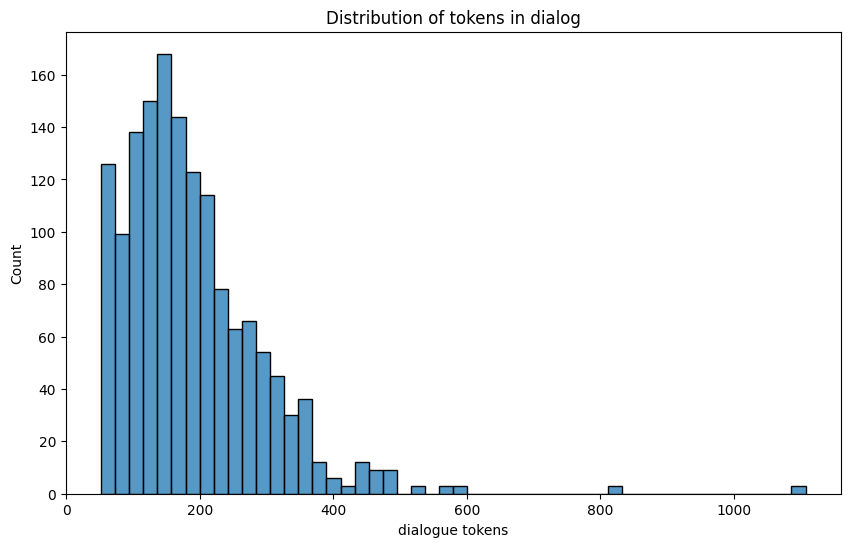

In [6]:
plt.figure(figsize = (10, 6))
sns.histplot(data=dialog_df["dialogue"].str.len() / 4)
plt.title("Distribution of tokens in dialog")
plt.xlabel("dialogue tokens")
plt.show()

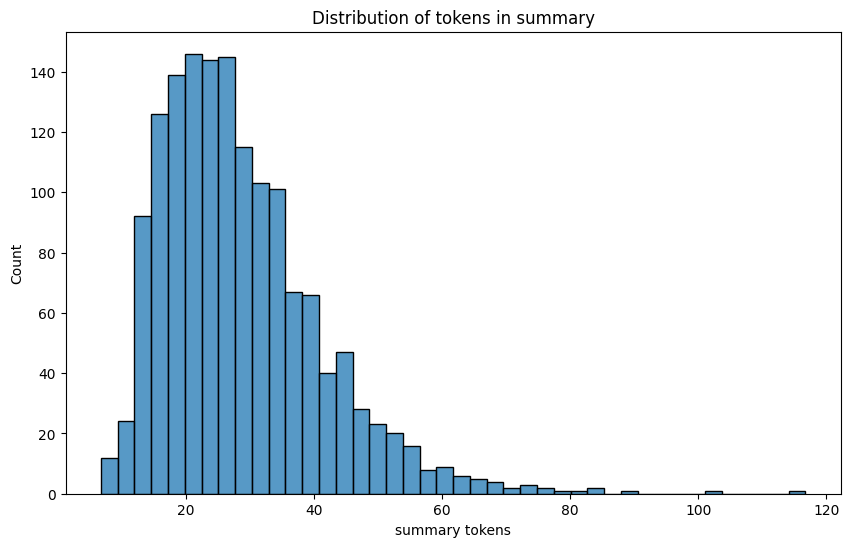

In [7]:
plt.figure(figsize = (10, 6))
sns.histplot(data=dialog_df["summary"].str.len() / 4)
plt.title("Distribution of tokens in summary")
plt.xlabel("summary tokens")
plt.show()

In [8]:
dialog_df.groupby(by="topic").count()

,id,dialogue,summary
topic,,,
\n\nentertainment activity schedule,1,1,1
\ncheck-up in hospital,1,1,1
\nconversation in car,1,1,1
\nintroducing new friend,1,1,1
\nqualification inquiry.,1,1,1
...,...,...,...
workplace,2,2,2
workplace dressing style,1,1,1
worry about someone,1,1,1


In [15]:

dialog_df["dialogue_tokens"] = dialog_df["dialogue"].apply(lambda x: len(x) / 4)
dialog_df.head()

,id,dialogue,summary,topic,dialogue_tokens
0,test_0_1,"#Person1#: Ms. Dawson, I need you to take a di...",Ms. Dawson helps #Person1# to write a memo to ...,communication method,362.75
1,test_0_2,"#Person1#: Ms. Dawson, I need you to take a di...",In order to prevent employees from wasting tim...,company policy,362.75
2,test_0_3,"#Person1#: Ms. Dawson, I need you to take a di...",Ms. Dawson takes a dictation for #Person1# abo...,dictation,362.75
3,test_1_1,#Person1#: You're finally here! What took so l...,#Person2# arrives late because of traffic jam....,public transportation,302.25
4,test_1_2,#Person1#: You're finally here! What took so l...,#Person2# decides to follow #Person1#'s sugges...,transportation,302.25


In [17]:
dialog_df["summary_tokens"] = dialog_df["summary"].apply(lambda x: len(x) / 4)
dialog_df.head()

,id,dialogue,summary,topic,dialogue_tokens,summary_tokens
0,test_0_1,"#Person1#: Ms. Dawson, I need you to take a di...",Ms. Dawson helps #Person1# to write a memo to ...,communication method,362.75,40.75
1,test_0_2,"#Person1#: Ms. Dawson, I need you to take a di...",In order to prevent employees from wasting tim...,company policy,362.75,51.75
2,test_0_3,"#Person1#: Ms. Dawson, I need you to take a di...",Ms. Dawson takes a dictation for #Person1# abo...,dictation,362.75,43.75
3,test_1_1,#Person1#: You're finally here! What took so l...,#Person2# arrives late because of traffic jam....,public transportation,302.25,38.50
4,test_1_2,#Person1#: You're finally here! What took so l...,#Person2# decides to follow #Person1#'s sugges...,transportation,302.25,30.75


In [11]:
len(dialog_df.iloc[1499, 1]) / 4

209.25

In [16]:
data = []
dialog_df["dialogue"].apply(lambda x: data.append(len(x.split(" "))))
average_text_len = mean(data)
median_text_len = median(data)
total_words = sum(data)
average_adult_wpm = 236 # https://wordsrated.com/reading-speed-statistics/


print(f"Average text length by words: {math.ceil(average_text_len)}.\nMedian Text length by words: {math.ceil(median_text_len)}.\nTotal amount of text by words: {math.ceil(total_words)}\n\
Estimated time to read all text in hours: {math.ceil(((total_words / average_adult_wpm) / 60))}\nEstimated time per person in a group of 4: {math.ceil(14 / 4)}")

Average text length by words: 127.
Median Text length by words: 113.
Total amount of text by words: 190440
Estimated time to read all text in hours: 14
Estimated time per person in a group of 4: 4
